# Version 2

- 採用窮舉法生成路徑，根據 Layout 中所定義車輛數來排列組合。

- 起點（start）即為當前位置。

- 主機（car1）不含空路徑，其他車子會有空路徑，以模擬真實狀況。

- 直接跳轉至 [使用者介面](#使用者介面) 介紹。

In [9]:
import networkx as nx
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import dask.dataframe as dd

In [10]:
class Path_Utils:

    @staticmethod
    def find_all_paths(graph, start_nodes, end_nodes):

        all_paths = []
        for start_node in start_nodes:
            for end_node in end_nodes:
                if start_node != end_node:
                    paths = nx.all_simple_paths(graph, start_node, end_node)
                    all_paths.extend(paths)
    
        return all_paths
    
    @staticmethod
    def find_all_pairs(all_paths):

        pairs = [(path[0], path[-1]) for path in all_paths]
        pairs = set(pairs)
        return pairs
    
    @staticmethod
    def find_all_ends(pairs):

        feasible_ends = {start: [] for start, _ in pairs}
        for start, end in pairs:
            feasible_ends[start].append(end)
        return feasible_ends
    
    @staticmethod
    def paths_to_df(all_paths):

        paths_dict = {}
        for path in all_paths:
            start = path[0]
            end = path[-1]
            if (start, end) not in paths_dict:
                paths_dict[(start, end)] = [[]] # add empty path to this pair
                paths_dict[(start, end)].append(path)
            else:
                paths_dict[(start, end)].append(path)
        # convert feasible paths into df
        df = pd.DataFrame.from_dict(paths_dict, orient='index')
        df['index'] = df.index
        df[['start', 'end']] = df['index'].apply(pd.Series)
        df.drop(['index'], axis=1, inplace=True)
        df = df.melt(id_vars=['start', 'end'])
        df.drop(['variable'], axis=1, inplace=True)
        df.dropna(inplace=True)
        df.rename(columns={'value': 'path'}, inplace=True)
        return df
        
    @staticmethod
    def multiple_path_df_to_one(path_dfs):

        concatenated_df = pd.concat([df.assign(**{'constraint': key}) for key, df in path_dfs.items()])
        # remove duplicates paths, includes empty paths
        concatenated_df['path'] = concatenated_df['path'].map(str)
        concatenated_df = concatenated_df.drop_duplicates()
        concatenated_df['path'] = concatenated_df["path"].map(ast.literal_eval)
        concatenated_df.reset_index(drop=True, inplace=True)
        concatenated_df = concatenated_df[['constraint', 'start', 'end', 'path']]

        return concatenated_df
    
    @staticmethod
    def path_distance(path, edge_distances):

        # edge_distances = nx.get_edge_attributes(weighted_graph, 'weight')
        if isinstance(path, list):
            return sum(edge_distances[path[i], path[i+1]] for i in range(len(path)-1))
        if isinstance(path, set):
            return sum(edge_distances[edge] for edge in path)   

In [11]:
class Layout:

    def __init__(self, ncars):
        self.__ncars = ncars
    
        self.__map = nx.DiGraph()
        self.__has_constraint = False
        self.__constraints = {}

        self.__feasible_pairs = None
        self.__feasible_ends = None
        self.__feasible_paths = None  

    
    def set_weighted_edges(self, edges):
        
        self.__map.add_weighted_edges_from(edges)

    
    def add_constraint(self, constraint:dict):
        # constraint has 3 keys: name, start, end
        name = constraint['name']
        start_nodes = constraint['start']
        end_nodes = constraint['end']

        if not self.__has_constraint:            
            self.__has_constraint = True
        if len(self.__map.nodes) == 0:
            raise AttributeError('Set edges first. Run set_weighted_edges(). ')
        if len(start_nodes) < self.__ncars:
            raise ValueError('Starting points must not be less than the number of cars. Try another constraint setting.')
        for node in start_nodes:
            if node not in self.__map.nodes:
                raise ValueError(f'Invalid starting points. Point ID {node} is not in the map.')
        for node in end_nodes:
            if node not in self.__map.nodes:
                raise ValueError(f'Invalid ending points. Point ID {node} is not in the map.')

        self.__constraints[name] = {'start': start_nodes, 'end': end_nodes}


    def initialize(self):

        if len(self.__map.nodes) == 0:
            raise AttributeError('Set edges first. Run set_weighted_edges(). ')

        if self.__has_constraint:
            
            self.__feasible_pairs = {}
            self.__feasible_ends = {}
            path_dfs = {}

            for key in self.__constraints.keys():
                start_nodes = self.__constraints[key]['start']
                end_nodes = self.__constraints[key]['end']

                all_paths = Path_Utils.find_all_paths(self.__map, start_nodes, end_nodes)
                self.__feasible_pairs[key] = Path_Utils.find_all_pairs(all_paths)
                # ends        
                self.__feasible_ends[key] = Path_Utils.find_all_ends(self.__feasible_pairs[key])
                # paths
                # first save it in a dict, then convert to df        
                path_dfs[key] = Path_Utils.paths_to_df(all_paths)
                self.__feasible_paths = Path_Utils.multiple_path_df_to_one(path_dfs)

        else:
            nodes = self.__map.nodes
            all_paths = Path_Utils.find_all_paths(self.__map, start_nodes=nodes, end_nodes=nodes)        
            self.__feasible_pairs = Path_Utils.find_all_pairs(all_paths)
            # feasible ends
            # in dict, key is start, value is end
            self.__feasible_ends = Path_Utils.find_all_ends(self.__feasible_pairs)
            # feasible paths       
            self.__feasible_paths = Path_Utils.paths_to_df(all_paths)

        # return self

    
    def get_feasible_ends(self):
        
        if self.__feasible_ends is None:
            raise AttributeError('Run initialize() to set feasible ends in the layout.')
        return self.__feasible_ends
    
    
    def has_constraint(self):
        return self.__has_constraint

        
    def get_feasible_pairs(self):

        if self.__feasible_pairs is None:
            raise AttributeError('Run initialize() to set feasible pairs in the layout.')
        return self.__feasible_pairs
    
        
    def get_feasible_paths(self, include_empty_path=True):
        # with each call, it should return a copy of the df

        if self.__feasible_paths is None:
            raise AttributeError('Run initialize() to set feasible paths in the layout.')
        if include_empty_path:
            return self.__feasible_paths.copy()
        else:
            df = self.__feasible_paths.copy().explode('path')
            df = df.dropna(subset=['path'])
            if len(df.columns) == 4:
                df = df.groupby(['constraint', 'start', 'end'], as_index=False).agg(list)
            elif len(df.columns) == 3:
                df = df.groupby(['start', 'end'], as_index=False).agg(list)
            return df
        
    
    def get_map(self):

        if self.__map is None:
            raise AttributeError('Set edges first. Run set_weighted_edges(). ')
        return self.__map
    
    def get_ncars(self):
        return self.__ncars
    
    
    def num_of_distinct_paths(self):

        if self.__feasible_paths is None:
            raise AttributeError('Run initialize() to set feasible paths in the layout.')
        return len(self.__feasible_paths.index)

In [12]:
class Draw_layout:

    def __init__(self, layout:Layout):
        self.__map = layout.get_map()
        self.__pos = None
        self.__labels = None


    def set_coords(self, coords:dict):
        self.__pos = coords


    def set_special_attrs(self, attrs:dict):
        self.__labels = attrs
        

    def draw(self):

        if len(self.__map.nodes) < 50:
            plt.figure(figsize=(10, 6))
        else:
            plt.figure(figsize=(20, 12))
            
        if self.__pos is not None:
            nx.draw(self.__map, pos=self.__pos, with_labels=True, node_color='lightblue')
        else:
            nx.draw(self.__map, with_labels=True, node_color='lightblue')
        if self.__labels is not None:
            pos_attrs = {}        
            for node in self.__labels.keys():
                if node < 8:
                    pos_attrs[node] = (self.__pos[node][0] + 1, self.__pos[node][1])
                else:
                    pos_attrs[node] = (self.__pos[node][0] - 0.8, self.__pos[node][1] + 1)

            nx.draw_networkx_labels(self.__map, pos=pos_attrs, labels=self.__labels)
        plt.show()

In [13]:
class Table(object):
    def __init__(self, layout: Layout):
        
        self.__layout = layout
        self.__ncars = layout.get_ncars()   
        # penalty
        self.__penalty_align = None
        self.__penalty_opposite = None
        self.__penalty_table = None
        # table
        self.__main_df = None


    def set_penalty(self, align, opposite):

        if isinstance(align, (int, float)) and isinstance(opposite, (int, float)):
            self.__penalty_align = align
            self.__penalty_opposite = opposite
        else:
            raise TypeError('Penalty must be an integer or a float.')
        
        
    def create_penalty_table(self):

        if self.__penalty_align is None or self.__penalty_opposite is None:
            raise AttributeError('Penalties not defined. Run set_penalty() first. ')

        edges_dist = nx.get_edge_attributes(self.__layout.get_map(), 'weight')

        # convert path to edges (set of tuple)
        # merge 2 df in cross method
        # compare overlaps in align and opposite directions
        # compute distances in overlaps
        # weight and sum distances into penalty
        # drop unnecessary columns
        # convert path into string representation of list

        df_path_main = self.__layout.get_feasible_paths(include_empty_path=False)
        if len(df_path_main) > 3:
            df_path_main.drop(['constraint'], axis=1, inplace=True)
        df_path_main.rename({"path": 'path_main', 'start': 'start_main', 'end': 'end_main'}, axis = 1, inplace=True)        
        df_path_main['edges_path_main'] = df_path_main['path_main'].apply(lambda path: set([(path[i], path[i+1]) for i in range(len(path)-1) if path]))
        
        df_path_other = self.__layout.get_feasible_paths(include_empty_path=True)
        if len(df_path_other) > 3:
            df_path_other.drop(['constraint'], axis=1, inplace=True)
        df_path_other.rename({'path': 'path_other', 'start': 'start_other', 'end': 'end_other'}, axis = 1, inplace=True)
        df_path_other['edges_align'] = df_path_other['path_other'].apply(lambda path: set([(path[i], path[i+1]) for i in range(len(path)-1) if path]))
        df_path_other['edges_opposite'] = df_path_other['path_other'].apply(lambda path: set([(path[i+1], path[i]) for i in range(len(path)-1)]))

        merged = df_path_main.merge(df_path_other, how='cross')
        merged['overlaps_align'] = np.vectorize(lambda s1, s2: s1.intersection(s2))(merged['edges_path_main'], merged['edges_align'])
        merged['overlaps_align_dist'] = merged['overlaps_align'].apply(lambda overlaps: Path_Utils.path_distance(overlaps, edges_dist))
        merged['overlaps_opposite'] = np.vectorize(lambda s1, s2: s1.intersection(s2))(merged['edges_path_main'], merged['edges_opposite'])
        merged['overlaps_opposite_dist'] = merged['overlaps_opposite'].apply(lambda overlaps: Path_Utils.path_distance(overlaps, edges_dist))

        merged.drop(['edges_path_main', 'edges_align', 'edges_opposite', 'overlaps_align', 'overlaps_opposite'], axis=1, inplace=True)
        merged['penalty'] = merged['overlaps_align_dist'] * self.__penalty_align + merged['overlaps_opposite_dist'] * self.__penalty_opposite

        merged.drop(['overlaps_align_dist', 'overlaps_opposite_dist'], axis=1, inplace=True)
        merged['path_main'] = merged['path_main'].map(str) # for merging to main
        merged['path_other'] = merged['path_other'].map(str) # for merging to main

        self.__penalty_table = merged

    
    def join_penalty_to_main(self, idx):

        if self.__main_df is None:
            raise AttributeError('The main table is not created. Run create() first. ')      

        if self.__penalty_table is None:
            raise AttributeError('The penalty table is not created. Run create_penalty_table() first. ')

        current_penalty_table = self.__penalty_table.copy()

        current_penalty_table.rename(
            columns={'path_other': f'path_{idx}', "start_other": f"start_{idx}", 'end_other': f'end_{idx}', 'penalty': f"penalty_{idx}"}, 
            inplace=True
        )     

        # if main_df too large, consider using dask here
        if len(self.__main_df.index) < 10 ** 7:

            self.__main_df = self.__main_df.merge(
                current_penalty_table, how='left', 
                left_on=['path_main', f'path_{idx}', 'start_main', f"start_{idx}", 'end_main', f"end_{idx}"], 
                right_on = ['path_main', f'path_{idx}', 'start_main', f"start_{idx}", 'end_main', f"end_{idx}"]
            )           

        else:

            dd_main_df = dd.from_pandas(self.__main_df, npartitions=(len(self.__main_df.index) // 10 ** 7) + 1)
            dd_penalty_table = dd.from_pandas(current_penalty_table, npartitions=1)

            dd_merged = dd_main_df.merge(
                dd_penalty_table, how='left', 
                left_on=['path_main', f'path_{idx}', 'start_main', f"start_{idx}", 'end_main', f"end_{idx}"], 
                right_on = ['path_main', f'path_{idx}', 'start_main', f"start_{idx}", 'end_main', f"end_{idx}"]
            )
            self.__main_df = dd_merged.compute()

        self.__main_df['path_main'] = self.__main_df['path_main']


    def add_reward(self):

        penalty_columns = self.__main_df.filter(like='penalty_').columns
        penalty_sum = self.__main_df[penalty_columns].sum(axis=1)
        reward_unscaled = penalty_sum + self.__main_df['main_distance']

        # rescale and transform
        min_value, max_value = reward_unscaled.min(), reward_unscaled.max()
        self.__main_df['reward'] = reward_unscaled.apply(lambda x: 1 - (x - min_value) / (max_value - min_value))        


    def create(self, output=False):

        if self.__penalty_align is None or self.__penalty_opposite is None:
            raise AttributeError('Penalty for reward not set. Run set_penalty() first. ')

        edge_distances = nx.get_edge_attributes(self.__layout.get_map(), 'weight')
        self.create_penalty_table()
        
    
        for i in range(self.__ncars):

            # add path for other cars
            # compute penalty between path of main vs path of others
            # join penalty to main at the end of each iteration
            
            idx = str(i+1)
            now_processing_df = None
            
            if i == 0:

                self.__main_df = self.__layout.get_feasible_paths(include_empty_path=False)
                if len(self.__main_df.columns) > 3:
                    self.__main_df.drop(['constraint'], axis=1, inplace=True)
                self.__main_df.columns += '_main'

                self.__main_df['main_distance'] = self.__main_df['path_main'].apply(lambda x: Path_Utils.path_distance(x, edge_distances))
                self.__main_df['path_main'] = self.__main_df['path_main'].map(str)

            else:
                now_processing_df = self.__layout.get_feasible_paths(include_empty_path=True)
                if len(now_processing_df.columns) > 3:
                    now_processing_df.drop(['constraint'], axis=1, inplace=True)
                now_processing_df.columns += f'_{idx}'

                # if main_df too large, consider using dask here
                self.__main_df = self.__main_df.merge(now_processing_df, how='cross')
                self.__main_df[f'path_{idx}'] = self.__main_df[f'path_{idx}'].map(str)
                self.join_penalty_to_main(idx) # has considered penalty parameters

        self.add_reward()
        # drop main_distance and penalty
        penalty_columns = self.__main_df.filter(like='penalty_').columns
        self.__main_df.drop(columns=['main_distance'], inplace=True)
        self.__main_df.drop(columns=penalty_columns, inplace=True)                        
        
        if output:
            return self.__main_df        
        

    def to_csv(self, file_path):
        
        if self.__main_df is None:
            raise AttributeError('The main table is not created. Run create() first. ')
        
        self.__main_df.to_csv(file_path, index=False)

# 使用者介面

參考場域:

![area_1a](https://i.imgur.com/NviPKtr.png)

### 設定場域

1. 初始化時，設定 AMR 總數。

2. 透過 set_weight_edges() 設定 edge 及 edge 距離，其中 node id 目前為使用者自行比照 flexsim 模型中的點位來定義。

3. 如果有 constaint，在這邊加入 constraint。

4. 完成時呼叫 initialize()，來產生生成資料需要使用到的屬性。

5. 若是只需要畫圖，則完成 edge 設定即可。

In [14]:
area_a = Layout(ncars=3)
area_a.set_weighted_edges([
    (1, 2, 6), (2, 3, 6), (3, 4, 6), (4, 5, 6), (5, 6, 3),
    (6, 7, 5), (7, 8, 5), (8, 9, 3), (9, 10, 6), (10, 11, 6),
    (11, 12, 6), (12, 13, 6), (13, 14, 4), (14, 15, 2), (15, 14, 2),
    (14, 1, 6)
])
area_a.add_constraint({
    'name':'case 1',
    'start':[13, 14, 15], 
    'end':[2, 3, 4, 5, 9, 10, 11, 12]
})
area_a.add_constraint({
    'name':'case 2',
    'start':[2, 3, 4, 5, 9, 10, 11, 12],
    'end': [8]
})
area_a.initialize()

/tmp/ipykernel_29210/340745829.py:45: FutureWarning: Returning a DataFrame from Series.apply when the supplied function returns a Series is deprecated and will be removed in a future version.
  df[['start', 'end']] = df['index'].apply(pd.Series)
/tmp/ipykernel_29210/340745829.py:45: FutureWarning: Returning a DataFrame from Series.apply when the supplied function returns a Series is deprecated and will be removed in a future version.
  df[['start', 'end']] = df['index'].apply(pd.Series)


### 將場域視覺化

1. 將場域傳入 Draw_Layout() 來初始化

2. 設定每個 node 的座標。(x, y) 的定義方式由使用者自行比對 flexsim 中模型物件位置。

3. 利用 set_special_attr()，來在特殊的 node 上加入 label。

4. 呼叫 draw() 來作圖。



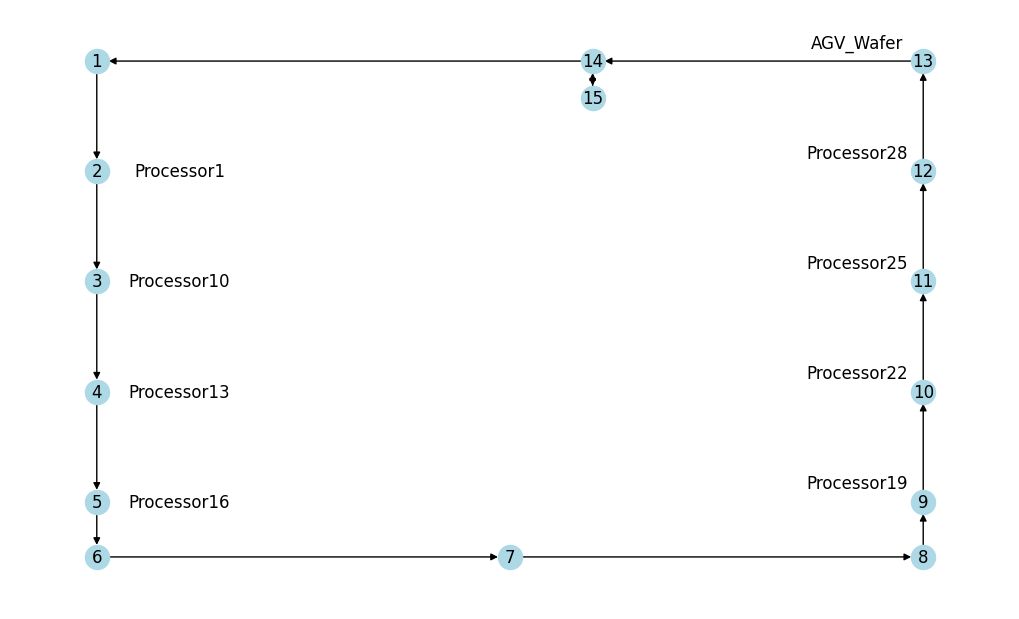

In [15]:
plot = Draw_layout(layout = area_a)
plot.set_coords({
    1: (0, 27), 2: (0, 21), 3: (0, 15), 4: (0, 9), 5: (0, 3), 6: (0, 0),
    7: (5, 0), 8: (10, 0), 9: (10, 3), 10: (10, 9), 11:(10, 15), 12: (10, 21),
    13: (10, 27), 14: (6, 27), 15: (6, 25)})
plot.set_special_attrs({
    13: 'AGV_Wafer', 2: 'Processor1', 3: 'Processor10', 4: 'Processor13', 5: 'Processor16',
    9: 'Processor19', 10: 'Processor22', 11: 'Processor25', 12: 'Processor28'})
plot.draw()

### 生成資料

1. 將場域傳入 Table() 來初始化，其中地圖、汽車數量、constraint 皆已定義在場域物件中。

2. 透過 set_penalty()，設定 reward 中順向與逆向會車的 penalty 參數。

3. 呼叫 create() 來生成資料，設定 output=True 則會將資料回傳。

4. 若要儲存結果，則在最後呼叫 to_csv()，將資料存成 csv 格式。

In [16]:
table = Table(layout=area_a)
table.set_penalty(align=0.4, opposite=0.8)
table.create(output=True)

,start_main,end_main,path_main,start_2,end_2,path_2,start_3,end_3,path_3,reward
0,13,2,"[13, 14, 1, 2]",13,2,[],13,2,[],0.965458
1,13,2,"[13, 14, 1, 2]",13,2,[],13,3,[],0.965458
2,13,2,"[13, 14, 1, 2]",13,2,[],13,4,[],0.965458
3,13,2,"[13, 14, 1, 2]",13,2,[],13,5,[],0.965458
4,13,2,"[13, 14, 1, 2]",13,2,[],13,9,[],0.965458
...,...,...,...,...,...,...,...,...,...,...
131067,12,8,"[12, 13, 14, 1, 2, 3, 4, 5, 6, 7, 8]",12,8,"[12, 13, 14, 1, 2, 3, 4, 5, 6, 7, 8]",5,8,"[5, 6, 7, 8]",0.417962
131068,12,8,"[12, 13, 14, 1, 2, 3, 4, 5, 6, 7, 8]",12,8,"[12, 13, 14, 1, 2, 3, 4, 5, 6, 7, 8]",9,8,"[9, 10, 11, 12, 13, 14, 1, 2, 3, 4, 5, 6, 7, 8]",0.279793
131069,12,8,"[12, 13, 14, 1, 2, 3, 4, 5, 6, 7, 8]",12,8,"[12, 13, 14, 1, 2, 3, 4, 5, 6, 7, 8]",10,8,"[10, 11, 12, 13, 14, 1, 2, 3, 4, 5, 6, 7, 8]",0.279793
131070,12,8,"[12, 13, 14, 1, 2, 3, 4, 5, 6, 7, 8]",12,8,"[12, 13, 14, 1, 2, 3, 4, 5, 6, 7, 8]",11,8,"[11, 12, 13, 14, 1, 2, 3, 4, 5, 6, 7, 8]",0.279793


In [17]:
table.to_csv('simulation_data.csv')